In [ ]:
from argparse import Namespace
from DAPT.tools import builder
from DAPT.utils.config import cfg_from_yaml_file
from DAPT.utils.parser import get_args
from density_decoding.utils.data_utils import IBLDataLoader
from matplotlib import pyplot as plt
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
dapt_args = get_args("--exp_name binned_spikes_velocity --ckpts experiments/finetune_modelnet/cfgs/binned_spikes_velocity/ckpt-best.pth --config DAPT/cfgs/finetune_modelnet.yaml --num_workers 2")
gmm_args = Namespace(pid="5246af08-0730-40f7-83de-29b5d62b9b6d", n_t_bins=30, prior_path=None, ephys_path="ephys_data/c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9_angelakilab_NYU_48", behavior="wheel_velocity", brain_region="all")
is_cls = gmm_args.behavior == "choice"

In [23]:
ibl_data_loader = IBLDataLoader(
    gmm_args.pid,
    n_t_bins = gmm_args.n_t_bins,
    prior_path = gmm_args.prior_path
)

print("available brain regions to decode:")
ibl_data_loader.check_available_brain_regions()

behavior = ibl_data_loader.process_behaviors(gmm_args.behavior)

spike_index = np.load(os.path.join(gmm_args.ephys_path, "spike_index.npy"))
spike_features_exp = np.load(os.path.join(gmm_args.ephys_path, "localization_results.npy"))
spike_times, spike_channels = spike_index.T

bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features_exp, gmm_args.brain_region
)

pulling data from ibl database ..
eid: c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9
pid: 5246af08-0730-40f7-83de-29b5d62b9b6d
number of trials found: 415 (active: 415)
prior for this session is not found.
found 415 trials from 65.80 to 2646.26 sec.
available brain regions to decode:
['CA1' 'CA3' 'DG-mo' 'DG-po' 'DG-sg' 'LP' 'TH' 'VISa6a' 'VISa6b' 'VISam6a'
 'VISpm2/3' 'VISpm4' 'VISpm5' 'VPL' 'VPM' 'ZI' 'bsc' 'fp' 'ml' 'or' 'root']


Process spike features: 100%|██████████| 415/415 [00:19<00:00, 20.76it/s]


### Visualize Trained Point-MAE Model

In [4]:
class SpikeEvents(Dataset):
    
    def __init__(self, spike_features, labels):
        self.spike_features = spike_features
        self.labels = labels
    
    def __len__(self):
        return len(self.spike_features)

    def __getitem__(self, index):
        spikes = torch.from_numpy(self.spike_features[index]).float()[:1024]
        # indices = torch.randperm(len(spikes))
        return "Trial", "Spikes", (spikes, self.labels[index])


class SpikeEventsBinned(SpikeEvents):

    # def __init__(self, *args, trial_spike_times, num_bins):
    #     super().__init__(*args)
    #     self.trial_spike_times = trial_spike_times
    #     self.num_bins = num_bins

    def __getitem__(self, index):
        max_spikes_trial = max(len(bin_spikes) for bin_spikes in self.spike_features[index])
        padded_spikes_trial = []
        for bin_spikes in self.spike_features[index]:
            padded_spikes_bin = np.concatenate([bin_spikes, np.zeros((max_spikes_trial - len(bin_spikes), bin_spikes.shape[1]))], axis=0)
            padded_spikes_trial.append(padded_spikes_bin)
        spikes_trial = torch.from_numpy(np.stack(padded_spikes_trial)).float()
        labels_trial = torch.from_numpy(self.labels[index]).float() if isinstance(self.labels[index], np.ndarray) else self.labels[index]
        return "Bins", "Spikes", (spikes_trial, labels_trial)

In [6]:
all_dataset = SpikeEventsBinned(bin_spike_features, behavior)
all_loader = DataLoader(all_dataset, batch_size=1, shuffle=False, drop_last=False, num_workers=0)
config = cfg_from_yaml_file(dapt_args.config)
config.npoints = 1024
config.max_epoch = 100
config.model.cls_dim = 2 if is_cls else gmm_args.n_t_bins
config.model.is_cls = is_cls
config.model.no_batchnorm = True
base_model = builder.model_builder(config.model)
base_model.load_model_from_ckpt(dapt_args.ckpts)
base_model.cuda()

test_pred = []
test_label = []

with torch.no_grad():
    for idx, (taxonomy_ids, model_ids, data) in enumerate(all_loader):
        points = data[0].cuda()
        label = data[1].cuda()
        logits = base_model(points)
        target = label.view(-1)
        pred = logits.argmax(-1).view(-1) if base_model.is_cls else logits.view(-1)
        test_pred.append(pred.detach())
        test_label.append(target.detach())

2025-04-28 20:44:52,665 - Transformer - INFO - Mismatched keys: []
2025-04-28 20:44:52,666 - Transformer - INFO - [Transformer] Successful Loading the ckpt from experiments/finetune_modelnet/cfgs/binned_spikes_velocity/ckpt-best.pth


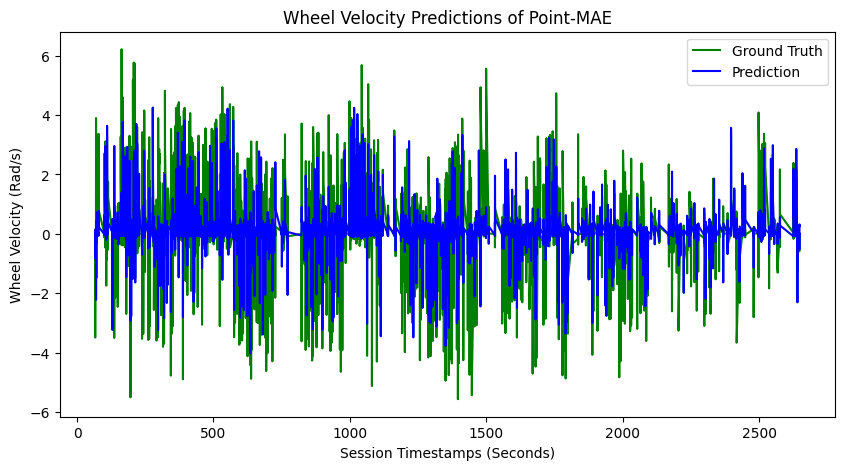

In [ ]:
test_pred_np, test_label_np = torch.cat(test_pred).cpu().numpy(), torch.cat(test_label).cpu().numpy()
timestamps = (ibl_data_loader.stim_on_times[..., np.newaxis] + ibl_data_loader.t_binning[np.newaxis, ...]).ravel()
velo_plot, velo_ax = plt.subplots(figsize=(10, 5))
velo_ax.plot(timestamps, test_label_np, color="green", label="Ground Truth")
velo_ax.plot(timestamps, test_pred_np, color="blue", label="Prediction")
velo_ax.set_xlabel("Session Timestamps (Seconds)")
velo_ax.set_ylabel("Wheel Velocity (Rad/s)")
velo_ax.set_title("Wheel Velocity Predictions of Point-MAE")
velo_ax.legend()

### Visualize trial information

In [ ]:
trial_slicer = ibl_data_loader.stim_on_times[..., np.newaxis].repeat(2, axis=1)
trial_slicer[:, 0] -= ibl_data_loader.t_before
trial_slicer[:, 1] += ibl_data_loader.t_after
spike_times_real = ibl_data_loader.sl.samples2times(spike_times)
spikes_in_trial = np.logical_and(spike_times_real[np.newaxis, ...] >= trial_slicer[:, :1],
                                 spike_times_real[np.newaxis, ...] <= trial_slicer[:, 1:]).any(axis=0)

Text(0, 0.5, 'Channel Number')

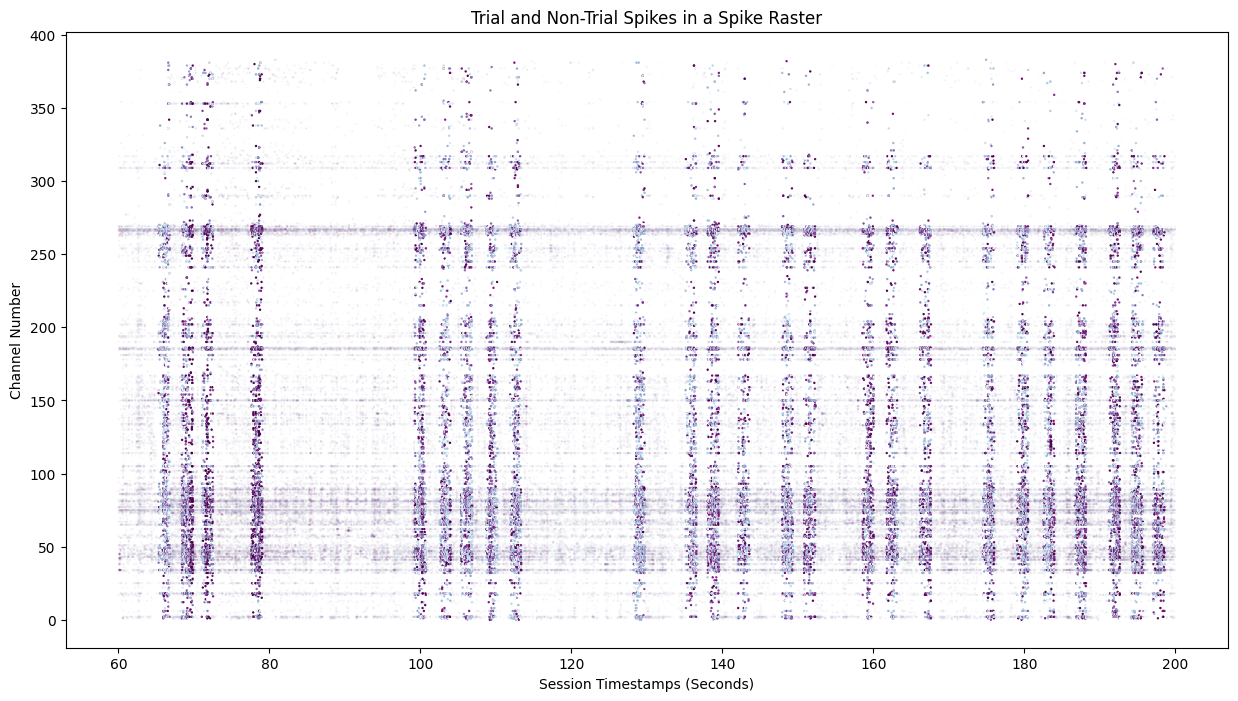

In [130]:
spike_trial_fig, spike_trial_ax = plt.subplots(figsize=(15, 8))
spikes_in_time = np.logical_and(spike_times_real > 0, spike_times_real < 200)
spikes_plot_trial, spikes_plot_rest = np.logical_and(spikes_in_trial, spikes_in_time), np.logical_and(~spikes_in_trial, spikes_in_time)
spike_magnitudes = np.linalg.norm(spike_features_exp, axis=1)
spikes_zscored = np.clip(0.5 + (spike_magnitudes - np.average(spike_magnitudes[spikes_in_time])) / np.std(spike_magnitudes[spikes_in_time]) / 2, 0, 1)
spike_intense = plt.get_cmap("BuPu")(spikes_zscored)
spike_trial_ax.scatter(spike_times_real[spikes_plot_trial], spike_channels[spikes_plot_trial], s=0.5, c=spike_intense[spikes_plot_trial])
spike_trial_ax.scatter(spike_times_real[spikes_plot_rest], spike_channels[spikes_plot_rest], s=0.5, c=spike_intense[spikes_plot_rest], alpha=0.04)
spike_trial_ax.set_title("Trial and Non-Trial Spikes in a Spike Raster")
spike_trial_ax.set_xlabel("Session Timestamps (Seconds)")
spike_trial_ax.set_ylabel("Channel Number")